In [ ]:
pip install pydicom nibabel numpy torch torchvision segmentation-models-pytorch scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9e7663b45ba3ed18279d08a9b974cbcd73d20876224594ed52ec6d04c1175946
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=3678b4b688cc419c25c36050f448d8a531e95ee2d300e33e2e72f5670c437d59
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pyto

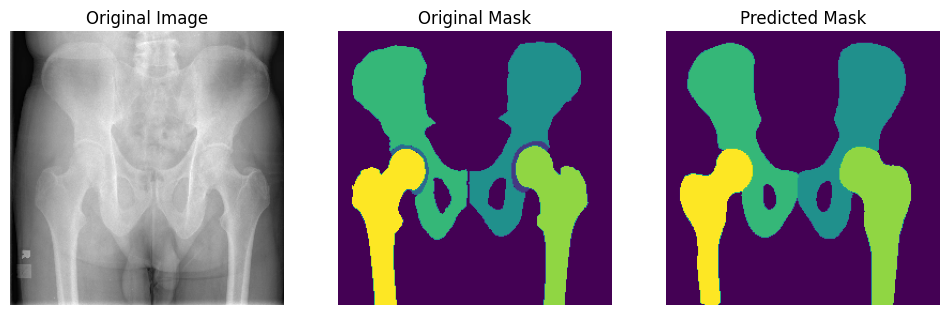

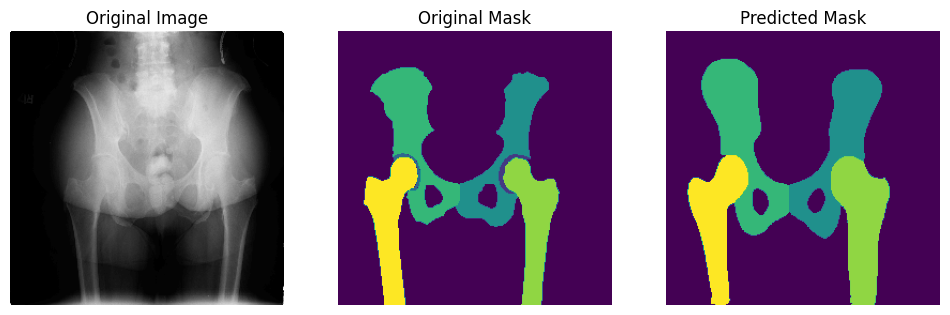

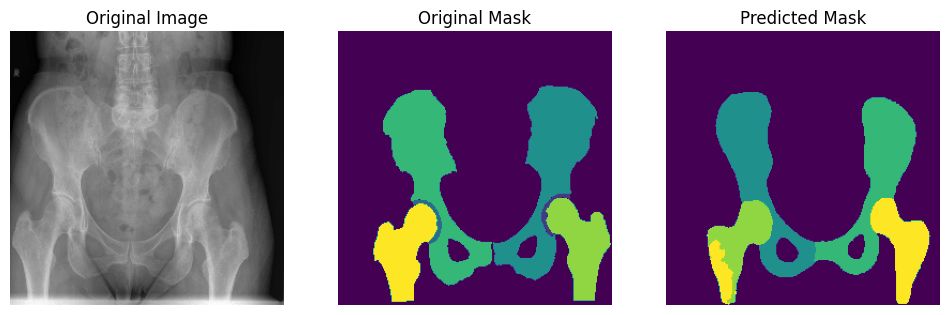

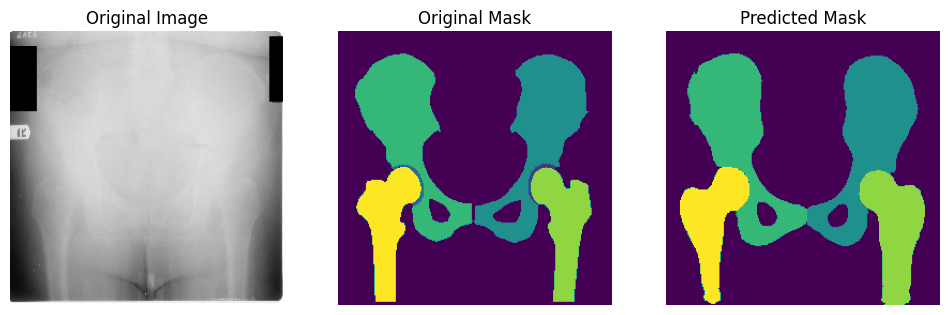

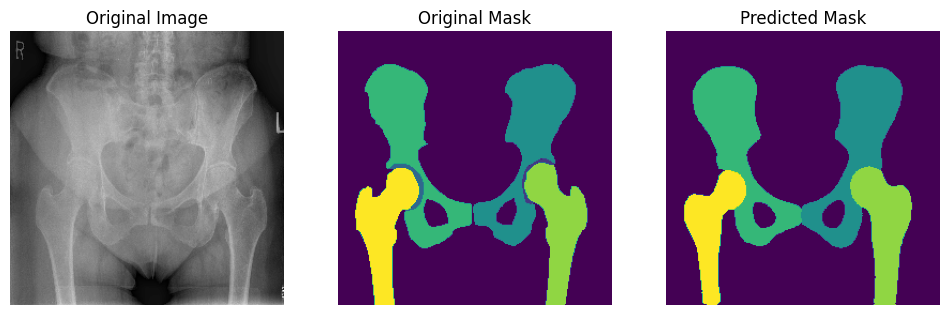

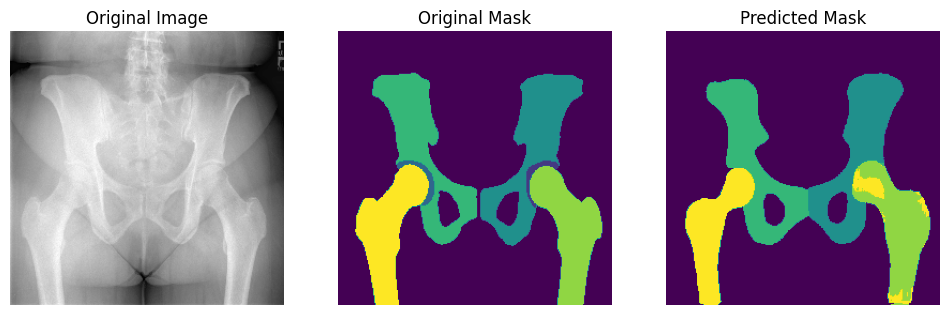

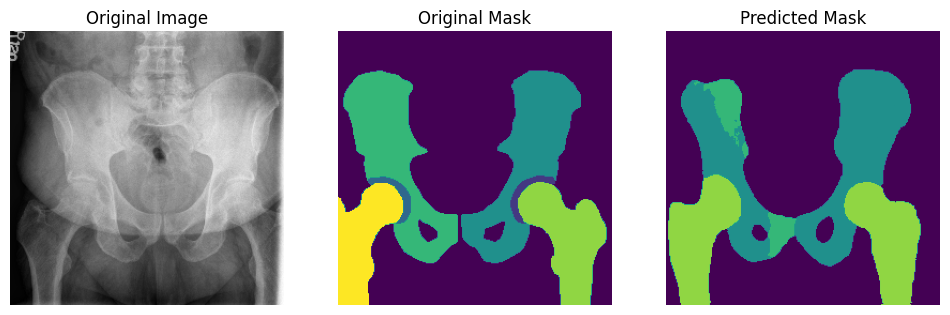

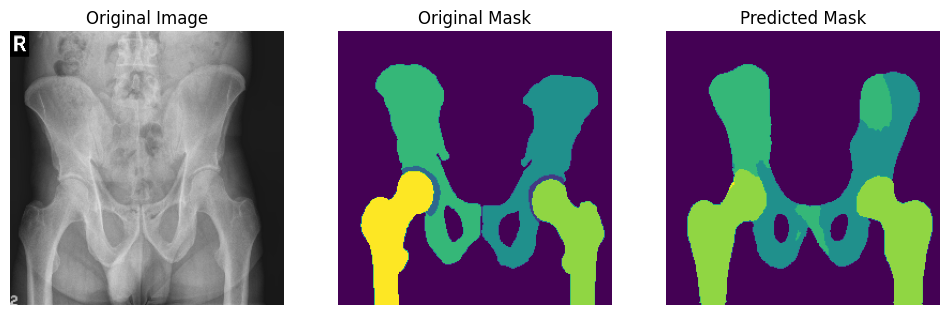

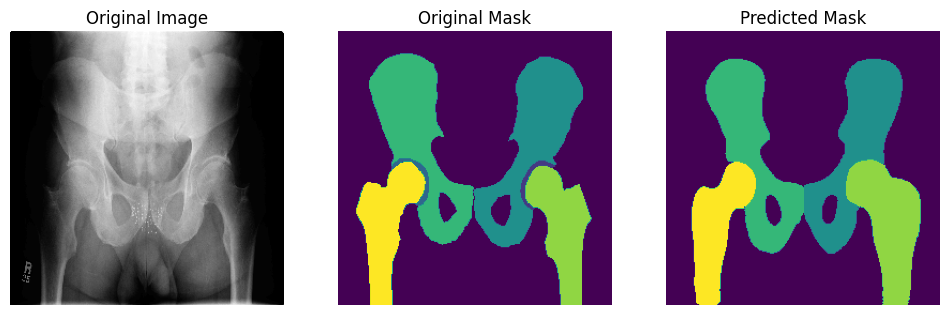

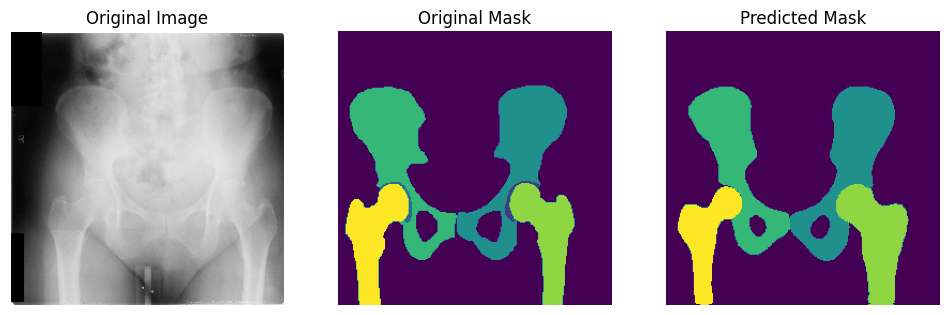

In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
import random
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

img_root = 'JHIR_Hip_Knee_Datasets/Hip/Images'
mask_root = 'JHIR_Hip_Knee_Datasets/Hip/Annotations'

# Define the compute_iou function
def compute_iou(pred, target, num_classes):
    pred = (pred > 0.5).float()
    intersection = torch.sum(pred * target, dim=(1, 2))
    union = torch.sum((pred + target) > 0, dim=(1, 2))
    iou = (intersection + 1e-10) / (union + 1e-10)
    return torch.mean(iou).item()

class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[idx]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[idx]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]
        annotation_data = np.rot90(annotation_data, k=3)
        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        return image, annotation_data_onehot

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask


image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))

paired_files = list(zip(image_files, mask_files))

random.shuffle(paired_files)

train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
], is_check_shapes=False)

num_classes = 7
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=1,
    classes=num_classes,
)

saved_model_path = 'unet_resnet18_multiclass_model_weights No aug.pth'
checkpoint = torch.load(saved_model_path)
model.load_state_dict(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def create_test_loader(test_pairs, augmentations, num_classes):
    test_set = MulticlassHipSegmentationDataset(
        img_root,
        mask_root,
        [p[0] for p in test_pairs],
        [p[1] for p in test_pairs],
        num_classes,
        transforms=augmentations
    )
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    return test_loader


def visualize_single_sample(images, masks, model):
    model.eval()
    with torch.no_grad():
        images = images.squeeze(0)
        masks = masks.squeeze(0)
        outputs = model(images.unsqueeze(0))
        original_mask = torch.argmax(masks, dim=0).cpu().numpy()
        predicted_mask = torch.argmax(outputs.squeeze(0), dim=0).cpu().numpy()
        image = images.permute(1, 2, 0).cpu().numpy()

        if image.shape[-1] == 1:
            image = image.squeeze(-1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(original_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
        plt.title('Original Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

random_10_pairs = random.sample(test_pairs, 10)

random_10_loader = create_test_loader(random_10_pairs, augmentations, num_classes)

for images, masks in random_10_loader:
    visualize_single_sample(images, masks, model)
